### PID control of `Panda`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from pid import PID_ControllerClass
np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


### Parse `Panda`

In [2]:
env = MuJoCoParserClass(name='Panda',xml_path='../asset/panda/franka_panda.xml')
env.init_viewer(window_width=0.3,window_height=0.3,
                cam_azimuth=80.0,cam_distance=3.0,
                cam_elevation=-30.0,cam_lookat=np.array([0,0,1.5]))
PID = PID_ControllerClass(
    name = 'PID',dim = env.n_rev_joint,
    k_p = 1000.0, k_i = 0.0, k_d = 100.0, # <= D gain is super important
    out_min = env.torque_range[env.rev_joint_idxs,0],
    out_max = env.torque_range[env.rev_joint_idxs,1],
    ANTIWU  = True)
print ("Done.")

Creating window glfw
Done.


### PID control

In [3]:
env.reset()
PID.reset()
# Desired position target for PID control
q_des1 = np.array([0,0,0,-90,0,90,0])*np.pi/180.0
q_des2 = np.array([0,0,-90,0,90,90,0])*np.pi/180.0
q_des3 = np.array([0,0,90,-90,0,90,0])*np.pi/180.0
# Buffers
max_tick    = 3000
sec_list    = np.zeros(shape=max_tick)
q_list      = np.zeros(shape=(max_tick,env.n_rev_joint))
q_des_list  = np.zeros(shape=(max_tick,PID.dim))
torque_list = np.zeros(shape=(max_tick,env.n_rev_joint))
while env.tick < max_tick:
    if (env.tick/max_tick) < 1/3: q_des = q_des1
    elif (env.tick/max_tick) < 2/3: q_des = q_des2
    else: q_des = q_des3
    # PID control
    PID.update(x_trgt=q_des)
    PID.update(t_curr=env.get_sim_time(),x_curr=env.get_q_pos(q_pos_idxs=env.rev_joint_idxs),VERBOSE=False)
    torque = PID.out()
    env.step(ctrl=torque,ctrl_idxs=env.rev_joint_idxs)
    env.render()
    # Append
    sec_list[env.tick-1]      = env.get_sim_time()
    q_list[env.tick-1,:]      = env.get_q_pos(q_pos_idxs=env.rev_joint_idxs)
    q_des_list[env.tick-1,:]  = q_des
    torque_list[env.tick-1,:] = torque
print ("Done.")

Done.


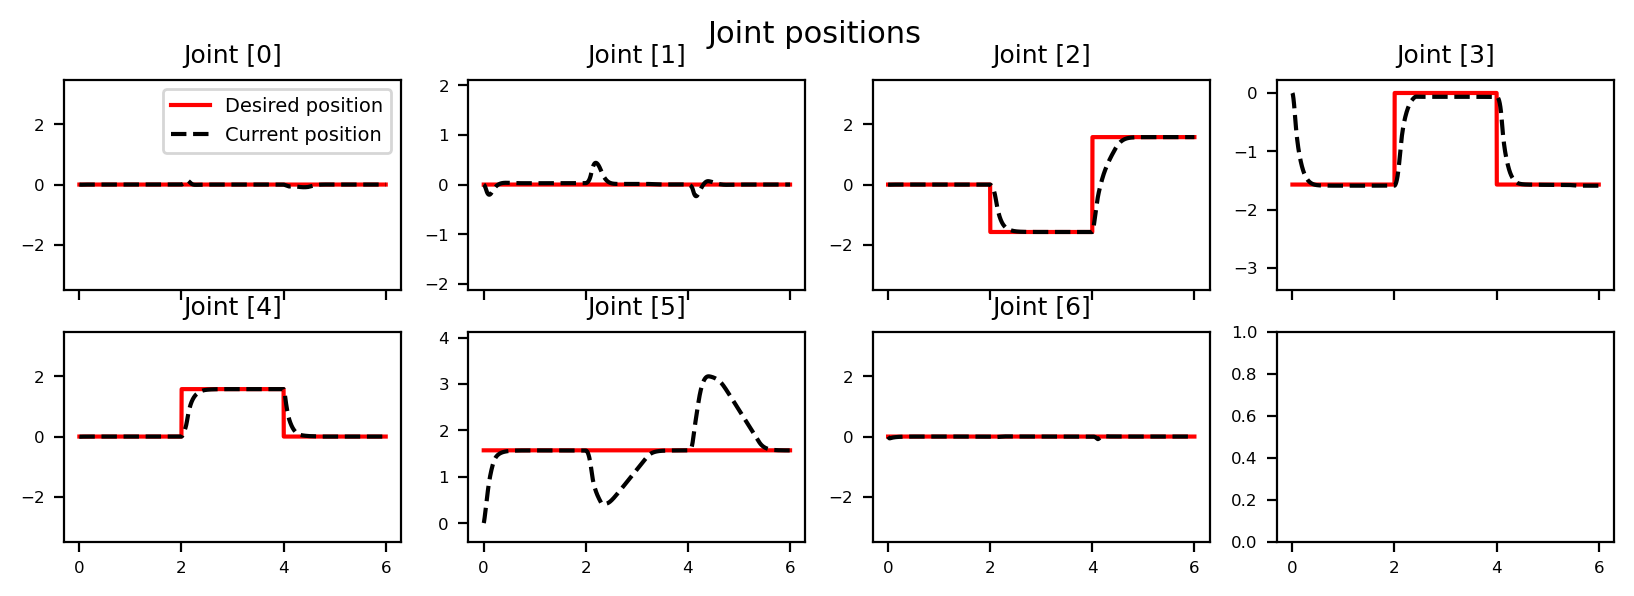

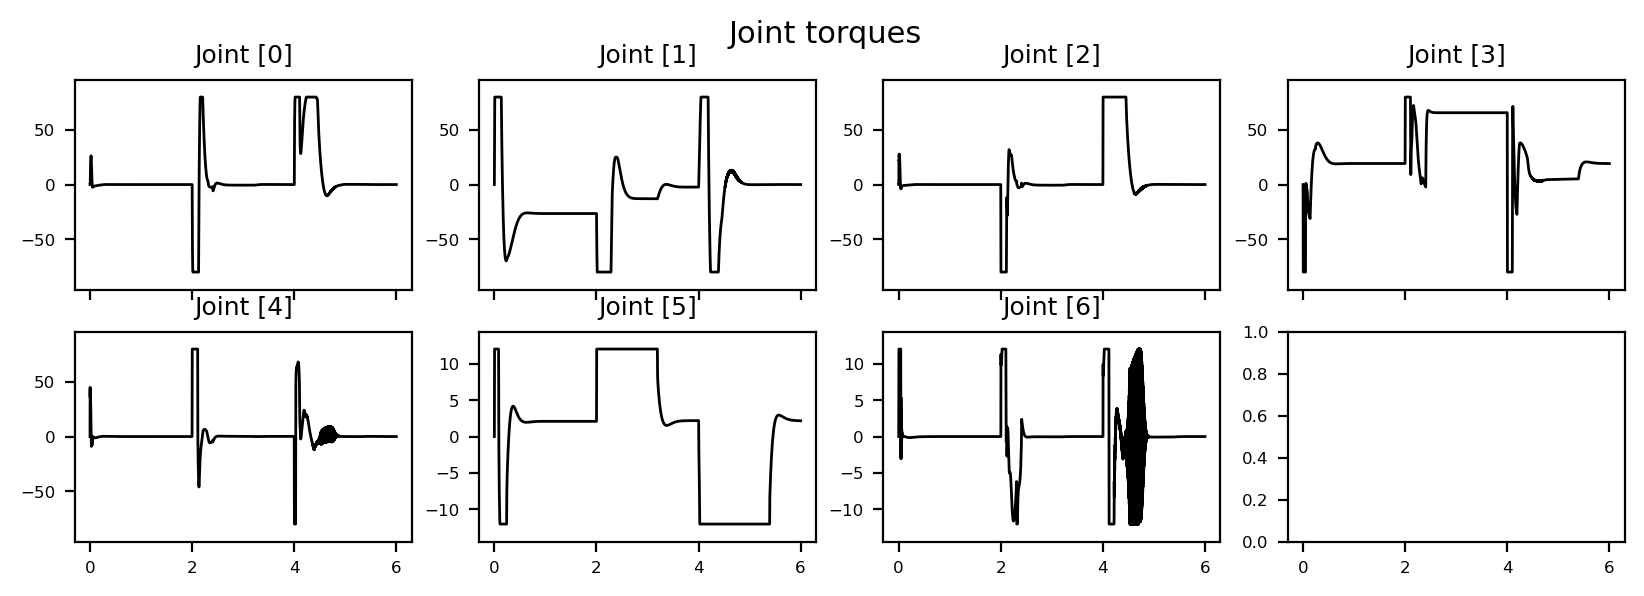

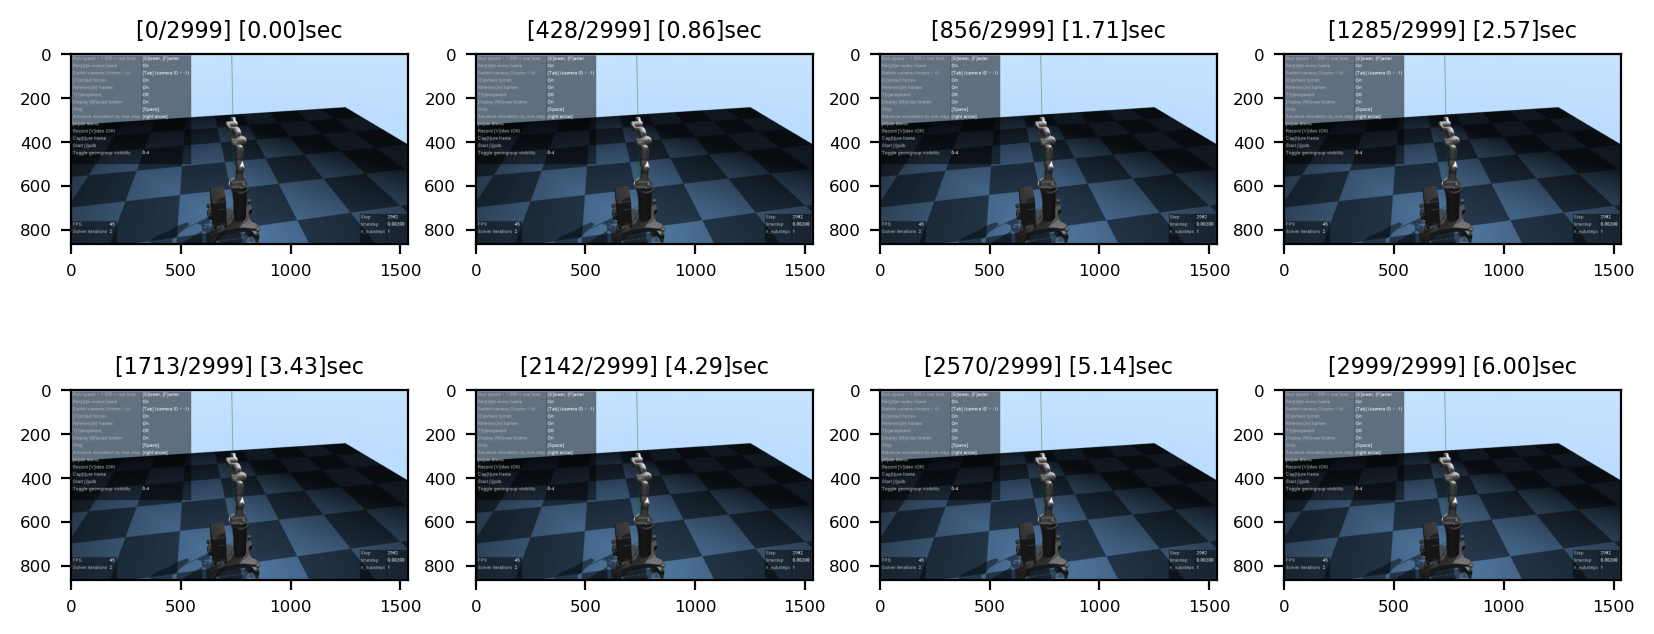

In [4]:
# Plot joint positions
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(10,3))
fig.suptitle("Joint positions", fontsize=11)
for a_idx,ax in enumerate(axs.ravel()):
    if (a_idx >= PID.dim): continue
    ax.plot(sec_list,q_des_list[:,a_idx],'-',color='r',label='Desired position')
    ax.plot(sec_list,q_list[:,a_idx],'--',color='k',label='Current position')
    qmarg = 0.1*(env.joint_range[a_idx,1]-env.joint_range[a_idx,0])
    ax.set_ylim(bottom=env.joint_range[a_idx,0]-qmarg,top=env.joint_range[a_idx,1]+qmarg)
    ax.set_title('Joint [%d]'%(a_idx),fontsize=9)
    if a_idx == 0: ax.legend(fontsize=7)
plt.show()
# Plot joint torques
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(10,3))
fig.suptitle("Joint torques", fontsize=11)
for a_idx,ax in enumerate(axs.ravel()):
    if (a_idx >= PID.dim): continue
    ax.plot(sec_list,torque_list[:,a_idx],'-',color='k',label='',lw=1)
    tmarg = 0.1*(env.torque_range[a_idx,1]-env.torque_range[a_idx,0])
    ax.set_ylim(bottom=env.torque_range[a_idx,0]-tmarg,top=env.torque_range[a_idx,1]+tmarg)
    ax.set_title('Joint [%d]'%(a_idx),fontsize=9)
plt.show()
# Plot snapshots for Panda with FK
fig = plt.figure(figsize=(10,4))
for idx,tick in enumerate(np.linspace(0,max_tick-1,8).astype(np.int32)):
    env.forward(q_pos=q_list[tick,:],q_pos_idxs=env.rev_joint_idxs)
    img = env.plot_scene(RETURN_IMG=True)
    ax = fig.add_subplot(2,4,idx+1)
    ax.imshow(img)
    ax.set_title('[%d/%d] [%.2f]sec'%(tick,max_tick-1,sec_list[tick]),fontsize=8)

### Terminate viewer

In [5]:
env.terminate_viewer()